<h1>Bitcoin in BigQuery Analaysis examples</h1>
<h2>Question 1</h2>
<h3>How many bitcoins are sent per day?</h3>


In [6]:
%%bq query --name data
#StandardSQL
SELECT o.day, SUM(o.satoshis)*0.00000001 AS btc FROM (
SELECT TIMESTAMP_MILLIS((timestamp - MOD(timestamp,86400000))) AS day, outputs.pubkey_base58 AS output_key, satoshis 
FROM 
  `bitcoin-bigquery.bitcoin.blocks` 
    JOIN
  UNNEST(transactions) AS transactions
    JOIN 
  UNNEST(transactions.outputs) AS outputs) AS o
GROUP BY day
ORDER BY day

# Visualise with Datalab commands 
http://googledatalab.github.io/pydatalab/google.datalab%20Commands.html
<br>Also check 
https://developers.google.com/chart/interactive/docs/quick_start <br>
For more chart customization optins

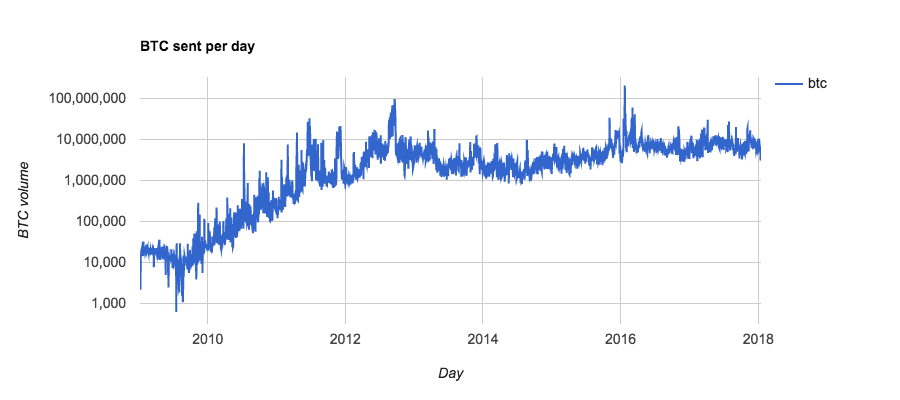

In [8]:
%chart line --data data --fields day,btc
title: BTC sent per day
height: 400
width: 900
hAxis:
  title: Day
vAxis:
  title: BTC volume
  scaleType: log

<h2>Question 2</h2>
<h3>How many addresses receive bitcoin per day?</h3>

In [10]:
%%bq query --name data_2
#StandardSQL
SELECT o.day, COUNT(DISTINCT(o.output_key)) AS recipients FROM
(
SELECT TIMESTAMP_MILLIS((timestamp - MOD(timestamp,86400000))) AS day, outputs.pubkey_base58 AS output_key, satoshis 
FROM 
  `bitcoin-bigquery.bitcoin.blocks` 
    JOIN
  UNNEST(transactions) AS transactions
    JOIN 
  UNNEST(transactions.outputs) AS outputs
) AS o
GROUP BY day
ORDER BY day


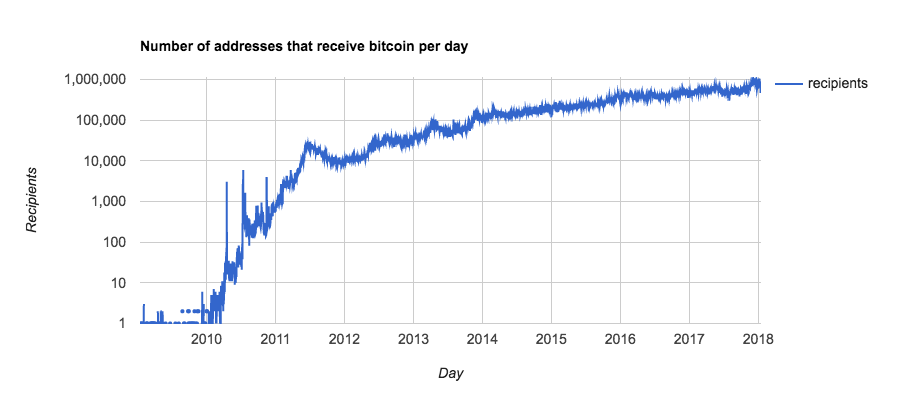

In [11]:
%chart line --data data_2 --fields day,recipients
title: Number of addresses that receive bitcoin per day

height: 400
width: 900
hAxis:
  title: Day
vAxis:
  title: Recipients
  scaleType: log

<h2>Question 3</h2>
<h3>What is the ratio of price (Bitcoins per US Dollar) to block difficulty, per day?</h3>

In [ ]:
%%bq query --name data_3
SELECT block_day,difficulty,btcusd FROM
(
SELECT
  DATE(coinbase.timestamp) AS coinbase_day,
  MAX(coinbase.priceUSD) AS btcusd
FROM
  `bitcoin-bigquery.bitcoin.coinbaseUSD` AS coinbase
GROUP BY coinbase_day
) AS coinbase,  
(
SELECT
  DATE(TIMESTAMP_MILLIS((timestamp - MOD(timestamp,86400000)))) AS block_day,
  CAST(AVG(difficulty) AS INT64) AS difficulty
FROM
  `bitcoin-bigquery.bitcoin.blocks`
GROUP BY block_day
) AS blocks
WHERE
  blocks.block_day = coinbase.coinbase_day
  
ORDER BY block_day


In [ ]:
%chart line --data data_3 --fields day,recipients
title: Number of addresses that receive bitcoin per day

height: 400
width: 900
hAxis:
  title: Day
vAxis:
  title: Recipients
  scaleType: log

<h2>Question 4</h2>
<h3>What is the balance of a certain address?</h3>
The address used here, 1F34duy2eeMz5mSrvFepVzy7Y1rBsnAyWC, is one of the addresses used in the <a href='https://en.wikipedia.org/wiki/WannaCry_ransomware_attack'>Wannacry ransomware attack</a> of 2017 as per this <a href='https://gist.github.com/rain-1/989428fa5504f378b993ee6efbc0b168'>factsheet</a> on github

In [25]:
%%bq query -n data_4

WITH
  c AS(
  SELECT
    DISTINCT transactions.transaction_id,
    inputs.pubkey_base58 AS input_key,
    outputs.pubkey_base58 AS output_key,
    outputs.satoshis,
    CASE
      WHEN inputs.pubkey_base58 = outputs.pubkey_base58 THEN 0
      WHEN outputs.pubkey_base58 = @address THEN outputs.satoshis
      ELSE -1 * outputs.satoshis
    END AS debit_credit
  FROM
    `bitcoin-bigquery.bitcoin.blocks`
  CROSS JOIN
    UNNEST (transactions) AS transactions
  CROSS JOIN
    UNNEST (transactions.inputs) AS inputs
  CROSS JOIN
    UNNEST (transactions.outputs) AS outputs
  WHERE
    inputs.pubkey_base58 = @address
    OR outputs.pubkey_base58 = @address)
SELECT
  SUM(debit_credit) *0.00000001 AS final_balance
FROM
  c

In [26]:
%%bq execute -q data_4
parameters:
- name: address
  type: STRING
  value: 115p7UMMngoj1pMvkpHijcRdfJNXj6LrLn

final_balance
4.34313811


<h2>Question 5</h2>
<h3>What are the associated addresses of a specific address i.e. both addresses appeared in one transaction as inputs?  </h3>
The address used here, 155fzsEBHy9Ri2bMQ8uuuR3tv1YzcDywd4, was randomly selected from the top 100 addresses on the Bitcoin Rich List.

In [23]:
%%bq query 
#StandardSQL
SELECT
  DISTINCT inputs.pubkey_base58 AS associated_addresses
FROM
  `bitcoin-bigquery.bitcoin.blocks`
CROSS JOIN
  UNNEST (transactions) AS transactions
CROSS JOIN
  UNNEST (transactions.inputs) AS inputs
WHERE
  transactions.transaction_id IN (
  SELECT
    transactions.transaction_id
  FROM
    `bitcoin-bigquery.bitcoin.blocks`
  CROSS JOIN
    UNNEST (transactions) AS transactions
  CROSS JOIN
    UNNEST (transactions.inputs) AS inputs
  WHERE
    inputs.pubkey_base58 = '155fzsEBHy9Ri2bMQ8uuuR3tv1YzcDywd4')


associated_addresses
16vV8JJ6rHFmo7gcNxDqyUb5wdpJVQkU7W
155fzsEBHy9Ri2bMQ8uuuR3tv1YzcDywd4
